<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# How to rediscover the Higgs boson yourself - with the coffea framework!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

This notebook builds on [HZZAnalysis.ipynb](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/HZZAnalysis.ipynb) in the same folder as this notebook. 

This notebook demonstrates the use of the coffea Python package, which combines many features useful for the manipulation and analysis of data from high-energy physics experiments. This package also allows for the use of parallel computing technologies such as Dask to speed up the processing of data and easily scale the analysis for computing clusters and super-computers. It uses a feature called processors where a user specifies the analysis they want and then coffea handles the parallelization for them.

The coffea framework is a prototype currently in development in collaboration with IRIS-HEP. This notebook was created as part of an [IRIS-HEP fellowship project](https://iris-hep.org/fellows/stormsomething.html), and a repository containing all the code and notes created for that project can be found [here](https://github.com/stormsomething/CoffeaHZZAnalysis). You can find out more about coffea [here](https://github.com/CoffeaTeam/coffea), and you can find out more about IRIS-HEP [here](https://iris-hep.org/).

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="images/feynman_diagrams/HZZ_feynman.png" style="width:40%"></CENTER>

<a id='contents'></a>

Contents: 

[Running a Jupyter notebook](#running) <br />
[First time setup on your computer (no need on mybinder)](#setup_computer) <br />
[To setup everytime](#setup_everytime) <br />
[Lumi and file path](#fraction) <br />
[Samples](#samples) <br />
[Changing a cut](#changing_cut) <br />
[Applying a cut](#applying_cut) <br />
[Plotting](#plotting) <br />
[What can you do to explore this analysis?](#going_further) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.

<a id='setup_computer'></a>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

In [1]:
import sys
# update the pip package installer
!{sys.executable} -m pip install --upgrade --user pip
# install required packages
!{sys.executable} -m pip install --upgrade --user coffea hist dask[distributed] numpy matplotlib

[Back to contents](#contents)

<a id='setup_everytime'></a>

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:
* coffea: prototype framework for analyzing collider event data in a horizontally-scaleable way
* hist: used to create, fill, and plot histograms
* dask: used to parallelize the processing of data in order to reduce run time
* numpy: provides array-based numerical calculation tools
* matplotlib: common tool for making plots, figures, images, visualisations

In [2]:
from coffea import processor # for horizontally-scaleable event data processing and analysis
from coffea.nanoevents import BaseSchema # schema used for processing uproot data with coffea
import hist # for constructing, filling, and plotting histograms
from dask.distributed import Client # for running the data analysis with parallelization
import re # for extracting the sample name from the data file name
import time # to measure time to analyse
import numpy as np # for working with numerical calculations on arrays
import matplotlib.pyplot as plt # for additional plotting features

import infofile # local file containing cross-sections, sums of weights, dataset IDs

[Back to contents](#contents)

<a id='fraction'></a>

## Lumi and file path

Variable definition related to the fraction of data used, where to access the input files

In [3]:
lumi = 10 # fb-1 # data_A+B+C+D

#tuple_path = 'Input/4lep/' # Use this for data stored locally
tuple_path = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/' # Use this to get data from the web

<a id='samples'></a>

## Samples

samples to process

In [4]:
samples = {
    
    'Data': [
        tuple_path + 'Data/data_A.4lep.root',
        tuple_path + 'Data/data_B.4lep.root',
        tuple_path + 'Data/data_C.4lep.root',
        tuple_path + 'Data/data_D.4lep.root'
    ],
    
    r'Background $Z,t\bar{t}$': [
        tuple_path + 'MC/mc_361106.Zee.4lep.root',
        tuple_path + 'MC/mc_361107.Zmumu.4lep.root',
        tuple_path + 'MC/mc_410000.ttbar_lep.4lep.root'
    ],
    
    r'Background $ZZ^*$': [
        tuple_path + 'MC/mc_363490.llll.4lep.root'
    ],
    
    r'Signal ($m_H$ = 125 GeV)': [
        tuple_path + 'MC/mc_345060.ggH125_ZZ4lep.4lep.root',
        tuple_path + 'MC/mc_344235.VBFH125_ZZ4lep.4lep.root',
        tuple_path + 'MC/mc_341964.WH125_ZZ4lep.4lep.root',
        tuple_path + 'MC/mc_341947.ZH125_ZZ4lep.4lep.root'
    ]
    
}

[Back to contents](#contents)

define function to calculate weight of MC event

In [5]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

define function to get cross-section weight

In [6]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

define function to calculate 4-lepton invariant mass.

Note: `lep_(pt|eta|phi|E)` are variable length lists of lepton momentum components for each event, represented by awkward arrays.

In [7]:
def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # [:, i] selects the i-th lepton in each event
    # first lepton is [:, 0], 2nd lepton is [:, 1] etc
    px_0 = lep_pt[:, 0]*np.cos(lep_phi[:, 0]) # x-component of lep[0] momentum
    py_0 = lep_pt[:, 0]*np.sin(lep_phi[:, 0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[:, 0]*np.sinh(lep_eta[:, 0]) # z-component of lep[0] momentum
    px_1 = lep_pt[:, 1]*np.cos(lep_phi[:, 1]) # x-component of lep[1] momentum
    py_1 = lep_pt[:, 1]*np.sin(lep_phi[:, 1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[:, 1]*np.sinh(lep_eta[:, 1]) # z-component of lep[1] momentum
    px_2 = lep_pt[:, 2]*np.cos(lep_phi[:, 2]) # x-component of lep[2] momentum
    py_2 = lep_pt[:, 2]*np.sin(lep_phi[:, 2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[:, 2]*np.sinh(lep_eta[:, 2]) # z-component of lep[3] momentum
    px_3 = lep_pt[:, 3]*np.cos(lep_phi[:, 3]) # x-component of lep[3] momentum
    py_3 = lep_pt[:, 3]*np.sin(lep_phi[:, 3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[:, 3]*np.sinh(lep_eta[:, 3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[:, 0] + lep_E[:, 1] + lep_E[:, 2] + lep_E[:, 3] # energy of 4-lepton system
    return np.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

[Back to contents](#contents)

<a id='changing_cut'></a>

## Changing a cut

If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "[Applying a cut](#applying_cut)" cell.

In [8]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    return (sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52)

[Back to contents](#contents)

<a id='applying_cut'></a>

## Applying a cut
If you add a cut: Cell -> Run All Below

In [9]:
# Define a processor class used by coffea to run data analysis
class Processor(processor.ProcessorABC):
    
    # Define how to process events from a data file
    def process(self, events):
        
        # Find what dataset these events are from
        dataset = events.metadata['dataset']
        
        # Cut events based on lepton charge
        events = events[~cut_lep_charge(events.lep_charge)]
        
        # Cut events based on lepton type
        events = events[~cut_lep_type(events.lep_type)]
        
        # Calculate the mllll for each event
        mllll = calc_mllll(events.lep_pt, events.lep_eta, events.lep_phi, events.lep_E)
        
        # If these events are real data
        if (dataset == 'Data'):
            
            # Create and fill a histogram of mllll
            mllllhist = (
                hist.Hist.new
                .Reg(34, 80, 250, name='mllll', label='4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]')
                .StrCat(['Data'], name='dataset', label='Dataset')
                .Weight()
                .fill(mllll=mllll, dataset=dataset)
            )
            
            # Output this histogram with the 'Data' key
            output = {
                'entries': {dataset: len(events)},
                'mllll': {'Data': mllllhist}
            }
            
        # If these events are Monte Carlo data
        else:
            
            # Extract the sample name from the filename metadata using regex
            sample = re.findall(r'mc_\d+\.(.+)\.4lep', events.metadata['filename'])[0]
            
            # Calculate the event weights
            xsec_weight = get_xsec_weight(sample)
            totalWeights = calc_weight(xsec_weight, events.mcWeight, events.scaleFactor_PILEUP, events.scaleFactor_ELE, events.scaleFactor_MUON, events.scaleFactor_LepTRIGGER)
            
            # Create and fill a histogram of mllll
            # This histogram has multiple string categories because we want to separate the different MC datasets in our plot
            mllllhist = (
                hist.Hist.new
                .Reg(34, 80, 250, name='mllll', label='4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]')
                .StrCat([r'Background $Z,t\bar{t}$', r'Background $ZZ^*$', r'Signal ($m_H$ = 125 GeV)'], name='dataset', label='Dataset')
                .Weight()
                .fill(mllll=mllll, dataset=dataset, weight=totalWeights)
            )
            
            # Output this histogram with the 'MC' key
            output = {
                'entries': {dataset: len(events)},
                'mllll': {'MC': mllllhist}
            }
        
        return output

    # Define postprocessing and how these histograms are combined (see coffea documentation for details)
    def postprocess(self, accumulator):
        return accumulator

[Back to contents](#contents)

This is where the processing happens

In [10]:
# Initialize the dask client
client = Client()

# Run the processor as a dask job on the samples defined above
# This may take a minute to run
output = processor.run_uproot_job(samples, # Dictionary of .root files to be processed
                                treename = 'mini', # Name of the tree we want in the .root file
                                processor_instance = Processor(), # Run the processor defined above
                                executor = processor.dask_executor, # Run using dask
                                executor_args = {'schema': BaseSchema, 'client': client} # Set the schema (see coffea documentation for details) and client for this job
                                )

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

[                                        ] | 0% Completed |  0.9s

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


[                                        ] | 0% Completed |  1.0s

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


[Back to contents](#contents)

<a id='plotting'></a>

## Plotting
If you only want to make a change in plotting: Cell -> Run All Below

Define function to plot the data

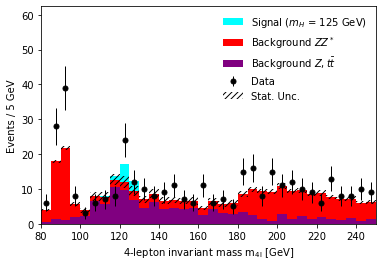

In [11]:
# Plot the histograms outputted by the processor
hist.Hist.plot1d(output['mllll']['Data'], histtype='errorbar', color='black')
hist.Hist.plot1d(output['mllll']['MC'], stack=True, histtype='fill', color=['purple', 'red', 'cyan'])

# Histogram bin parameters
xmin = 80
xmax = 250
step_size = 5

# Calculate where the center of each histogram bin is
bin_centers = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

# Calculate background statistical uncertainty
# For each histogram bin, this is equal to the square root of the sum of the background variances for that bin
# Remove the "[:,:2]" expressions to use all MC datasets with background and signal combined
mc_tot_var = np.sum(output['mllll']['MC'].variances()[:,:2], axis=1)
mc_err = np.sqrt(mc_tot_var)
mc_tot_height = np.sum(output['mllll']['MC'].values()[:,:2], axis=1)

# Plot background statistical uncertainty
plt.bar(bin_centers, # x
        2*mc_err, # heights
        alpha=0.5, # half transparency
        bottom=mc_tot_height-mc_err, color='none', 
        hatch='////', width=step_size, label='Stat. Unc.')

main_axes = plt.gca()

# Set plot limits
main_axes.set_xlim(left=xmin, right=xmax)
main_axes.set_ylim(bottom=0, top=np.amax(output['mllll']['Data'].values())*1.6)

# Set the y-axis label (x-axis is already set by the histograms)
main_axes.set_ylabel('Events / '+str(step_size)+' GeV')

# Show the dataset legend
main_axes.legend(frameon=False);

[Back to contents](#contents)

<a id='going_further'></a>

## What can you do to explore this analysis?

* Check how many events are being thrown away by each cut in '[Applying a cut](#applying_cut)'
* Add more cuts from the [Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0040) in '[Changing a cut](#changing_cut)' and '[Applying a cut](#applying_cut)'
* Add a plot to show the ratio between Data and MC other than Higgs
* Add a plot to show the invariant mass distribution of the sub-leading lepton pair, like [Figure 1 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0010)
* Get the estimated numbers of events, like [Table 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#tl0030)
* Add a plot of m12 against m34, like [Figure 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0030)
* Your idea!

[Back to contents](#contents)